<a href="https://colab.research.google.com/github/Dewwbe/Deep-Learning-Lab---05/blob/main/IT22910790Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# LSTM — IMDB Sentiment Analysis (IT22910790)

**Objective:** Implement an LSTM model for sentiment analysis on the IMDB movie reviews dataset and compare **Bidirectional vs Unidirectional** LSTM.

## What to do
1. Upload `IMDB Dataset.csv` to the notebook's root/content directory.  
2. This notebook is named `IT22910790Q3.ipynb`.  
3. Modify **Embedding `output_dim`**, **LSTM `units`**, **dropout**, **epochs**, and **batch_size** to see effects on performance.  
4. Train and record **Accuracy** and **F1-score**.  
5. Compare **Bidirectional LSTM** vs **Unidirectional LSTM** (both implemented below).  
6. If scores are low, try different architectures and hyperparameters.  
7. Write your analysis in the **Observations & Comparison** section at the end.


In [1]:

# === Setup (Colab users: uncomment the next line if needed) ===
# !pip install -q tensorflow pandas scikit-learn matplotlib

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

print("TensorFlow:", tf.__version__)


TensorFlow: 2.19.0


In [2]:

# === Load IMDB dataset ===
# Expected columns: 'review' and 'sentiment' with values 'positive' or 'negative'
df = pd.read_csv("IMDB Dataset.csv")
print("Data shape:", df.shape)
print(df.head())

# Basic cleaning: remove HTML tags, lowercase
def clean_text(t):
    t = re.sub(r"<.*?>", " ", str(t))  # remove HTML tags
    t = re.sub(r"[^a-zA-Z0-9' ]", " ", t)  # keep letters, numbers, apostrophes, spaces
    t = re.sub(r"\s+", " ", t).strip()
    return t.lower()

df["review_clean"] = df["review"].apply(clean_text)
df["label"] = (df["sentiment"].str.lower().map({"positive":1, "negative":0})).astype(int)

print("\nClass balance:\n", df["label"].value_counts())


Data shape: (50000, 2)
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

Class balance:
 label
1    25000
0    25000
Name: count, dtype: int64


In [3]:

# === Tokenize & Pad ===
VOCAB_SIZE = 20000  # changeable
MAXLEN = 200        # changeable

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(df["review_clean"])

sequences = tokenizer.texts_to_sequences(df["review_clean"])
X = pad_sequences(sequences, maxlen=MAXLEN, padding="post", truncating="post")
y = df["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((40000, 200), (10000, 200))

In [4]:

# === Hyperparameters (Tweak Here) ===
EMBED_DIM = 64    # e.g., 32, 64, 128
LSTM_UNITS = 64   # e.g., 32, 64, 128
DROPOUT = 0.3     # e.g., 0.2, 0.3, 0.5
EPOCHS = 3        # e.g., 3, 5, 10
BATCH_SIZE = 64   # e.g., 32, 64, 128

def make_model(bidirectional=True):
    model = Sequential()
    model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=MAXLEN))
    if bidirectional:
        model.add(Bidirectional(LSTM(LSTM_UNITS)))
    else:
        model.add(LSTM(LSTM_UNITS))
    model.add(Dropout(DROPOUT))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


In [5]:

# === Train Bidirectional LSTM ===
bi_model = make_model(bidirectional=True)
history_bi = bi_model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    verbose=1
)

# Evaluate
y_pred_bi_proba = bi_model.predict(X_test).ravel()
y_pred_bi = (y_pred_bi_proba >= 0.5).astype(int)

bi_acc = accuracy_score(y_test, y_pred_bi)
bi_f1 = f1_score(y_test, y_pred_bi)

print(f"Bidirectional LSTM — Accuracy: {bi_acc:.4f}, F1: {bi_f1:.4f}")
print("\nClassification Report (Bidirectional):\n", classification_report(y_test, y_pred_bi, target_names=["negative","positive"]))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
563/563 ━━━━━━━━━━━━━━━━━━━━ 150s 257ms/step - accuracy: 0.6883 - loss: 0.5603 - val_accuracy: 0.8652 - val_loss: 0.3336
Epoch 2/3
563/563 ━━━━━━━━━━━━━━━━━━━━ 200s 255ms/step - accuracy: 0.9032 - loss: 0.2622 - val_accuracy: 0.8708 - val_loss: 0.3131
Epoch 3/3
563/563 ━━━━━━━━━━━━━━━━━━━━ 206s 263ms/step - accuracy: 0.9317 - loss: 0.1939 - val_accuracy: 0.8723 - val_loss: 0.3751
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step
Bidirectional LSTM — Accuracy: 0.8756, F1: 0.8774

Classification Report (Bidirectional):
               precision    recall  f1-score   support

    negative       0.89      0.86      0.87      5000
    positive       0.86      0.89      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [6]:

# === Train Unidirectional LSTM ===
uni_model = make_model(bidirectional=False)
history_uni = uni_model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    verbose=1
)

# Evaluate
y_pred_uni_proba = uni_model.predict(X_test).ravel()
y_pred_uni = (y_pred_uni_proba >= 0.5).astype(int)

uni_acc = accuracy_score(y_test, y_pred_uni)
uni_f1 = f1_score(y_test, y_pred_uni)

print(f"Unidirectional LSTM — Accuracy: {uni_acc:.4f}, F1: {uni_f1:.4f}")
print("\nClassification Report (Unidirectional):\n", classification_report(y_test, y_pred_uni, target_names=["negative","positive"]))


Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


563/563 ━━━━━━━━━━━━━━━━━━━━ 85s 146ms/step - accuracy: 0.5231 - loss: 0.6907 - val_accuracy: 0.5520 - val_loss: 0.6890
Epoch 2/3
563/563 ━━━━━━━━━━━━━━━━━━━━ 139s 141ms/step - accuracy: 0.6383 - loss: 0.6347 - val_accuracy: 0.8085 - val_loss: 0.4738
Epoch 3/3
563/563 ━━━━━━━━━━━━━━━━━━━━ 85s 146ms/step - accuracy: 0.6819 - loss: 0.5820 - val_accuracy: 0.5400 - val_loss: 0.6856
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step
Unidirectional LSTM — Accuracy: 0.5397, F1: 0.6121

Classification Report (Unidirectional):
               precision    recall  f1-score   support

    negative       0.56      0.35      0.43      5000
    positive       0.53      0.73      0.61      5000

    accuracy                           0.54     10000
   macro avg       0.55      0.54      0.52     10000
weighted avg       0.55      0.54      0.52     10000



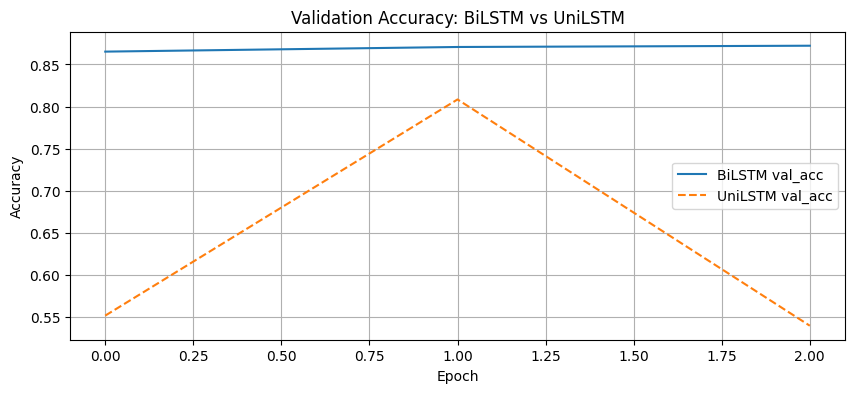

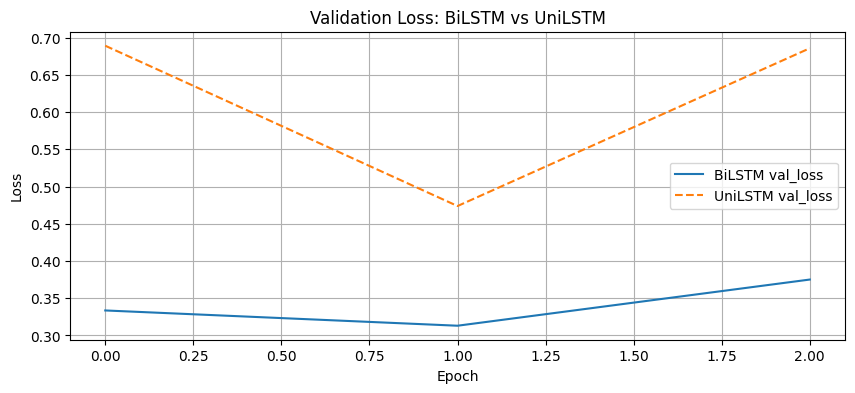

In [7]:

# === Plot training curves for quick visual comparison ===
plt.figure(figsize=(10,4))
plt.plot(history_bi.history["val_accuracy"], label="BiLSTM val_acc")
plt.plot(history_uni.history["val_accuracy"], label="UniLSTM val_acc", linestyle="--")
plt.title("Validation Accuracy: BiLSTM vs UniLSTM")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(history_bi.history["val_loss"], label="BiLSTM val_loss")
plt.plot(history_uni.history["val_loss"], label="UniLSTM val_loss", linestyle="--")
plt.title("Validation Loss: BiLSTM vs UniLSTM")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [8]:

# === Summary Table ===
summary = pd.DataFrame({
    "Model": ["Bidirectional LSTM", "Unidirectional LSTM"],
    "Accuracy": [bi_acc, uni_acc],
    "F1-score": [bi_f1, uni_f1],
    "EMBED_DIM": [EMBED_DIM, EMBED_DIM],
    "LSTM_UNITS": [LSTM_UNITS, LSTM_UNITS],
    "DROPOUT": [DROPOUT, DROPOUT],
    "EPOCHS": [EPOCHS, EPOCHS],
    "BATCH_SIZE": [BATCH_SIZE, BATCH_SIZE]
})
summary


,Model,Accuracy,F1-score,EMBED_DIM,LSTM_UNITS,DROPOUT,EPOCHS,BATCH_SIZE
0,Bidirectional LSTM,0.8756,0.877438,64,64,0.3,3,64
1,Unidirectional LSTM,0.5397,0.612052,64,64,0.3,3,64



## Observations & Comparison (Write Here)

- **Hyperparameters used:**  
  - `EMBED_DIM` = *[fill]*, `LSTM_UNITS` = *[fill]*, `DROPOUT` = *[fill]*, `EPOCHS` = *[fill]*, `BATCH_SIZE` = *[fill]*

- **Bidirectional vs Unidirectional Results:**  
  - **BiLSTM** Accuracy = *[fill]*, F1 = *[fill]*  
  - **UniLSTM** Accuracy = *[fill]*, F1 = *[fill]*

- **Analysis:**  
  - Discuss whether Bidirectional provided better features by reading context **from both past and future** within the sequence compared to Unidirectional, which reads **forward only**.  
  - Note if BiLSTM overfits (watch `val_loss`), and how **dropout** or reduced `LSTM_UNITS` affected generalization.  
  - Mention any improvements from increasing `EMBED_DIM`, adjusting `MAXLEN`, or changing `VOCAB_SIZE`.

- **Further improvements:**  
  - Add another LSTM layer (stacked), use **GRU**, try **pretrained embeddings** (e.g., GloVe), or apply **text augmentation** and **regularization** (L2, more dropout).  
  - Use **EarlyStopping** and **ModelCheckpoint** callbacks to capture the best validation model.
